In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
df = pd.read_csv('wine-reviews.csv',usecols = ['country','description','points','price','variety','winery'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
df = df.dropna(subset=['description','points'])

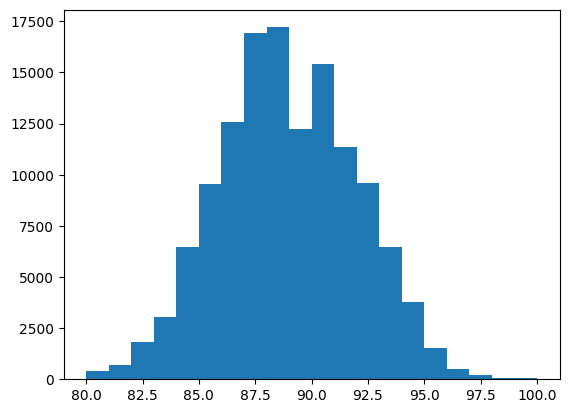

In [7]:
plt.hist(df.points,bins=20)
plt.show()

In [8]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

len(train), len(val), len(test)

(103976, 12997, 12998)

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [10]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [24]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.evaluate(train_data)
model.evaluate(val_data)

13/13 [==============================] - 1s 81ms/step - loss: 0.6927 - accuracy: 0.5492


[0.6927013397216797, 0.549203634262085]

In [27]:
history = model.fit(train_data, epochs=30, validation_data=val_data)

Epoch 1/30


102/102 [==============================] - 52s 514ms/step - loss: 0.5343 - accuracy: 0.7189 - val_loss: 0.3727 - val_accuracy: 0.8336
Epoch 2/30
102/102 [==============================] - 59s 578ms/step - loss: 0.3643 - accuracy: 0.8370 - val_loss: 0.3466 - val_accuracy: 0.8417
Epoch 3/30
102/102 [==============================] - 65s 634ms/step - loss: 0.3480 - accuracy: 0.8454 - val_loss: 0.3483 - val_accuracy: 0.8402
Epoch 4/30
102/102 [==============================] - 62s 610ms/step - loss: 0.3408 - accuracy: 0.8477 - val_loss: 0.3478 - val_accuracy: 0.8423
Epoch 5/30
102/102 [==============================] - 54s 524ms/step - loss: 0.3362 - accuracy: 0.8498 - val_loss: 0.3489 - val_accuracy: 0.8403
Epoch 6/30
102/102 [==============================] - 53s 519ms/step - loss: 0.3335 - accuracy: 0.8515 - val_loss: 0.3460 - val_accuracy: 0.8406
Epoch 7/30
102/102 [==============================] - 49s 485ms/step - loss: 0.3309 - accuracy: 0.8512 - val_loss: 0.3423 - val_accuracy: 0.8

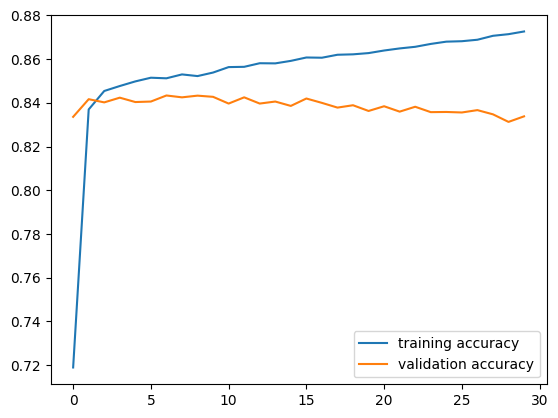

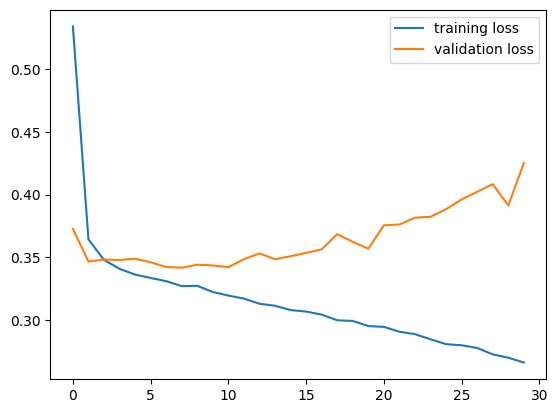

In [28]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [23]:
model.evaluate(test_data)

13/13 [==============================] - 1s 106ms/step - loss: 0.3527 - accuracy: 0.8394


[0.35266217589378357, 0.8394368290901184]